In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [224]:
url = 'https://raw.githubusercontent.com/vaibhavwalvekar/NYC-Flights-2013-Dataset-Analysis/master/flights.csv'
df = pd.read_csv(url)

url2 = 'https://raw.githubusercontent.com/vaibhavwalvekar/NYC-Flights-2013-Dataset-Analysis/master/weather.csv'
df2 = pd.read_csv(url2)

In [225]:
df['date'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['day'].astype(str)
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['hour'] % 24
df = df.fillna(method='ffill')
df['dep_delay'] = df['dep_delay'].astype(int)




In [226]:
df2['month'].iloc[1630] = 3
df2['day'].iloc[1630] = 10
df2['hour'].iloc[1630] = 2
df2 = df2.fillna(method='ffill')
df2['date'] = df2['year'].astype(int).astype(str) + '-' + df2['month'].astype(int).astype(str) + '-' + df2['day'].astype(int).astype(str)
df2['date'] = pd.to_datetime(df2['date'])

# 1. Как мерить "индекс опозданий" 

Попробуем измерить для каждого дня фиксированного месяца (допустим, речь будет идти об июне) "индекс опозданий" - некоторый показатель, на основе которого можно будет говорить о том, в какой день самолёты были более склонны вылетать по расписанию. Например, посчитаем его, вычислив среднее опоздание за день. Изобразим на графике (возьмем данные за один месяц, чтобы было нагляднее - за июль, например):

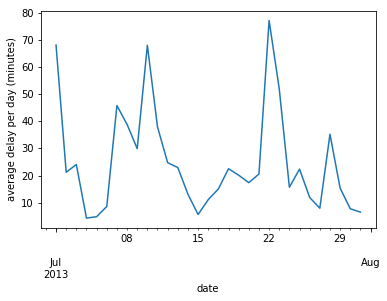

In [227]:
s1 = df.query('month == 7').groupby('date').mean().dep_delay
ax = s1.plot()
ax.set_ylabel('average delay per day (minutes)')
plt.show()

Попробуем, однако, использовать для измерения опозданий другой параметр: количество рейсов в день, опоздавших на 30 минут и более. 

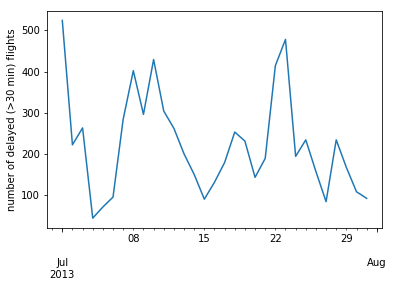

In [228]:
t1 = df.query('month == 7').date[df.dep_delay>30].value_counts().sort_index()
ax = t1.plot()
ax.set_ylabel('number of delayed (>30 min) flights')
plt.show()


Оказывается, что приведенные методы измерения условного "индекса опозданий" эквивалентны (значит, пользоваться можно любым из них). 

Для того чтобы продемонстрировать это наглядно, отнормируем оба столбца и изобразим их на общем графике:

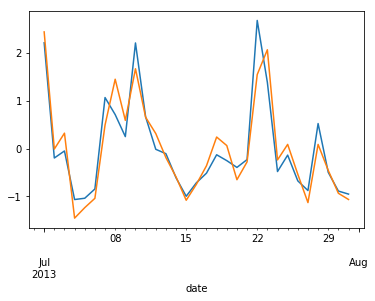

In [229]:
((s1-s1.mean()) / s1.std()).plot()
((t1-t1.mean()) / t1.std()).plot()
plt.show()

# 2. Опоздания по авиакомпаниям

Важно иметь представление о том, какие авиакомпании стараются вылетать вовремя, а каким более свойственны значительные задержки. 

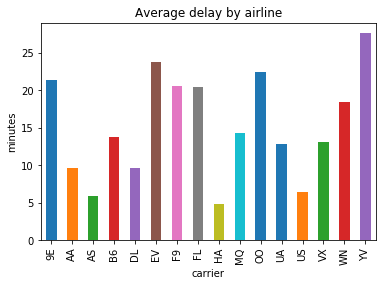

In [230]:
s2 = df.groupby('carrier').mean().dep_delay


ax = s2.plot(kind = 'bar', title = "Average delay by airline")
ax.set_ylabel('minutes')
plt.show()

Самыми пунктуальными оказались US Airways (US), Haiwaiian Airlines (HA) и Alaska Airlines (AS). Более склонны к задержкам Frontier Airlines (F9), ExpressJet (EV), Endeavor Air (YV) и AirTran Airways (FL). 

# 3. Зависимость опозданий от длины полёта

Традиционно самолётные рейсы делят на три типа в зависимости от длины полёта. Short-haul flights - это рейсы, протяженность которых составляет менее 700 миль; medium-haul flights - от 700 до 2400; long-haul flights - соответственно, от 2400. Посмотрим, связана ли задержка с длиной полёта:

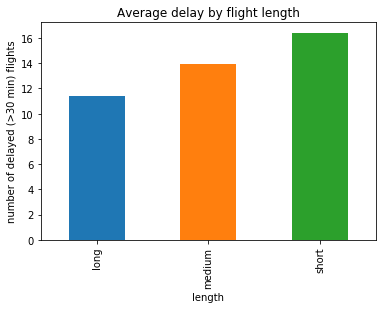

In [231]:

df['length'] = (df['distance'] > 700).astype(int) + (df['distance'] > 2400).astype(int)

df.loc[df.length == 0, 'length'] = 'short'
df.loc[df.length == 1, 'length'] = 'medium'
df.loc[df.length == 2, 'length'] = 'long'



s3 = df.groupby('length').mean()['dep_delay']
t3 = df.length[df.dep_delay>30].value_counts().sort_index() / df.length.value_counts().sort_index()

ax = s3.plot(kind="bar", title="Average delay by flight length")
ax.set_ylabel('number of delayed (>30 min) flights')

plt.show()


Оказывается, средняя задержка короткомагистрального рейса больше средней задержки дальнемагистрального рейса. 

# 4. Количество рейсов в зависимости от часа 

Рассмотрим, в какие часы вылетает наиболее количество рейсов. 

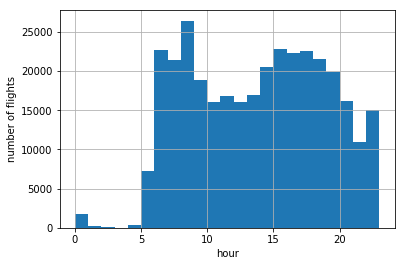

In [232]:
ax = df.hour.hist(bins = 23)
ax.set_ylabel('number of flights')
ax.set_xlabel('hour')


plt.show()

С 23 часов вечера до 5 часов утра аэропорт не работает на вылет, что наглядно видно на гистограмме.

Пиковая нагрузка приходится на утренние часы, а также на послеобеденное время. 

# 5. Опоздания в зависимости от часа

Рассмотрим почасовую долю рейсов, опоздавших боле чем на 15 минут, но менее, чем на час, а также почасовую долю опоздавших более чем на час рейсов, и изобразим их на графике:

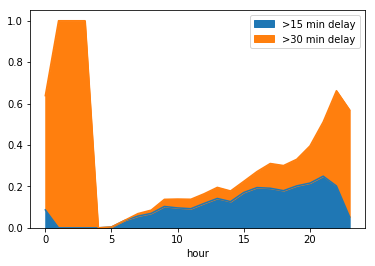

In [233]:
s5 = df.hour[df.dep_delay>15][df.dep_delay<=60].value_counts().sort_index()
u5 = df.hour[df.dep_delay>60].value_counts().sort_index()
t5 = df.hour.value_counts().sort_index()
s5 = s5 / t5
u5 = u5 / t5

df3 = pd.DataFrame({'>15 min delay': s5, '>30 min delay': u5})
ax = df3.plot(kind = 'area')
ax.set_xlabel('hour')

plt.show()

В пункте 4 было обращено внимание на то, что аэропорты закрываются в 23 часа и не работают до 5 утра. На представленном графике мы можем видеть, что почему в пункте 4 количество рейсов в эти часы все же не было нулевым: в это время из аэропортов вылетают сильно задержанные рейсы, которые должны были вылететь до 23 часов. 

Несмотря на то, что аэропорты примерно одинаково загружены утренние и вечерние часы, задержек всё-таки больше вечером. 

# 6. Опоздания в зависимости от аэропортов

Рассмотрим долю каждого аэропорта в общем числе рейсов, вылетевших с опозданием более чем на 30 минут. Для сравнения выведем pie-chart для долей аэропортов в числе всех рейсов. 

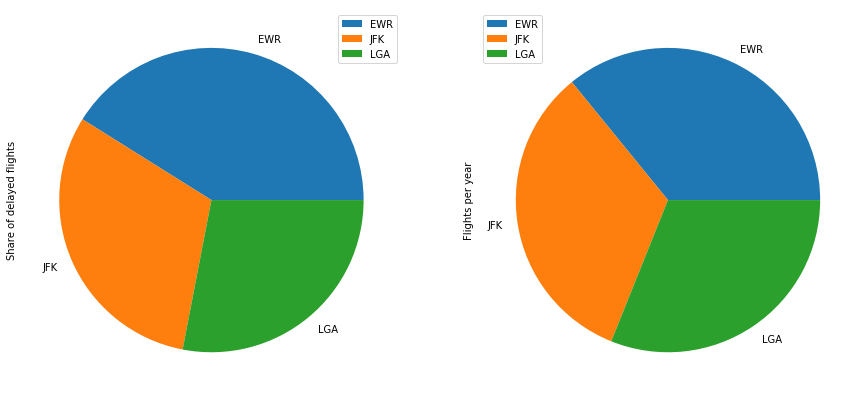

In [234]:

t6 = df.origin[df.dep_delay>30].value_counts().sort_index() / df[df.dep_delay>30].shape[0]
s6 = df.origin.value_counts().sort_index() 

s = pd.DataFrame({'Share of delayed flights': t6, 'Flights per year': s6}, index = ['EWR', 'JFK', 'LGA'])
s.plot.pie(subplots = True, figsize = (15, 10))
plt.show()

В то время как доли аэропортов в общем числе рейсов примерно одинаковы, доля аэропорта Newark Liberty в опоздавших рейсах составляет почти половину. 

# 7. Зависимость задержек от скорости ветра

Теперь изучим зависимость задержек рейсов от погодных условий. Во всех следующих пунктах будет применяться один и тот же метод: берутся данные о задержках вместе с данными об одном из погодных параметров за месяц, каждый раз - за разный, затем нормируются и помещаются на один график. 

Посмотрим, коррелируют ли между собой задержки (берем среднедневную задержку) и скорость ветра (берем среднедневную скорость ветра). Рассмотрим данные за февраль. 

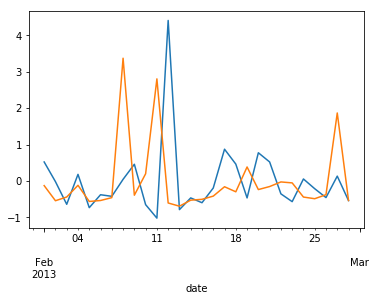

In [235]:

s7 = df2.query('month == 2').groupby('date').mean()['wind_speed']
t7 = df.query('month == 2').groupby('date').mean().dep_delay

((s7-s7.mean()) / s7.std()).plot()
((t7-t7.mean()) / t7.std()).plot()
plt.show()

Очевидно, коррелируют. 

# 8 Зависимость задержек от влажности

Рассмотрим данные за май. 

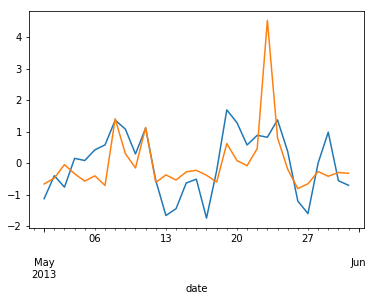

In [236]:

s8 = df2.query('month == 5').groupby('date').mean()['humid']
t8 = df.query('month == 5').groupby('date').mean().dep_delay

((s8-s8.mean()) / s8.std()).plot()
((t8-t8.mean()) / t8.std()).plot()
plt.show()

Фиксируем корреляцию. 

# 9 Зависимость задержек от осадков

Рассмотрим данные за август. 

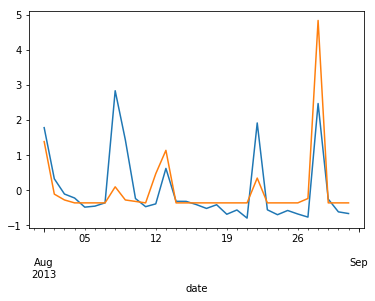

In [237]:


s9 = df.query('month == 8').groupby('date').mean()['dep_delay']
t9 = df2.query('month == 8').groupby('date').mean()['precip']

((s9-s9.mean()) / s9.std()).plot()
((t9-t9.mean()) / t9.std()).plot()
plt.show()

Корреляция очевидна. 

# 10 Зависимость задержек от видимости

Рассмотрим данные за март.

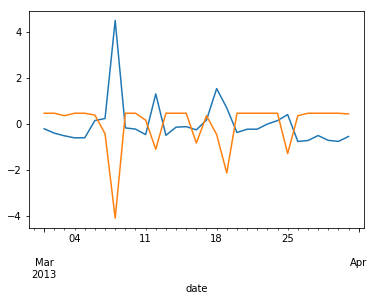

In [238]:

s10 = df.query('month == 3').groupby('date').mean()['dep_delay']
t10 = df2.query('month == 3').groupby('date').mean()['visib']

((s10-s10.mean()) / s10.std()).plot()
((t10-t10.mean()) / t10.std()).plot()
plt.show()

Фиксируем антикорреляцию: плохая видимость связана с сильными задержками. 